In [74]:
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [75]:
input_shape = (224,224,3)
resnet_weights_path = 'imagenet'
num_classes = 200
image_size = 224
batch_size = 64

In [76]:
data_generator = ImageDataGenerator(preprocessing_function = preprocess_input)
train_generator = data_generator.flow_from_directory('/Users/brycemartin/Documents/AI/bird-class-data/Train',
                                                    target_size = (image_size,image_size),
                                                    batch_size = batch_size, 
                                                    shuffle = True, 
                                                    class_mode = 'categorical')

test_generator = data_generator.flow_from_directory('/Users/brycemartin/Documents/AI/bird-class-data/Test',
                                                    target_size = (image_size,image_size),
                                                    batch_size = batch_size, 
                                                    shuffle = False,
                                                    class_mode = 'categorical')

Found 9414 images belonging to 200 classes.
Found 2374 images belonging to 200 classes.


In [77]:
base_model = ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path, input_shape=input_shape)
base_model.trainable = True  # Fine-tune the entire base model

inputs = tf.keras.Input(shape=input_shape)
x = base_model(inputs, training=True)
outputs = Dense(num_classes, activation='softmax')(x)
my_new_model = Model(inputs, outputs)

In [78]:
my_new_model.layers[0].trainable = True

In [79]:
base_model.trainable = False

my_new_model.compile(loss = 'categorical_crossentropy', 
                     optimizer='sgd', 
                     metrics=['accuracy'])

In [80]:
my_new_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 200)            │       409,800 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,997,512 (91.54 MB)

 Trainable params: 23,944,392 (91.34 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [81]:
with tf.device('/GPU:0'):   
    history = my_new_model.fit(
    train_generator,steps_per_epoch=100,batch_size= batch_size, validation_data=test_generator, epochs=5)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
 47/100 ━━━━━━━━━━━━━━━━━━━━ 1:54 2s/step - accuracy: 0.0069 - loss: 5.6683

KeyboardInterrupt: 

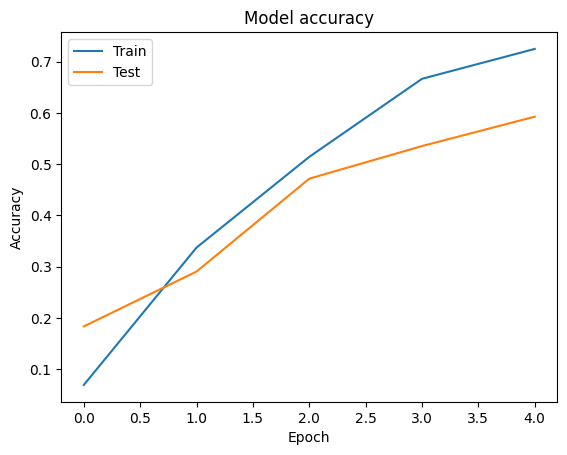

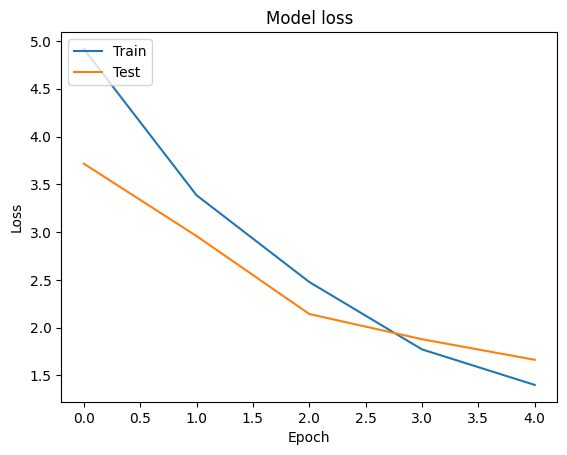

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


In [ ]:
my_new_model.evaluate(test_generator)

38/38 ━━━━━━━━━━━━━━━━━━━━ 20s 522ms/step - accuracy: 0.5845 - loss: 1.6571


[1.6626137495040894, 0.5926706194877625]

In [ ]:
my_new_model.save("./bird-classification.keras")